In [2]:
import numpy as np 
import pandas as pd 

#import statsmodels.api as sm
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt
%matplotlib inline

Обозначения:

p - глубина истории, сколько измерений назад учитываем в моделях
h - горизонт прогноза , на сколько измерений вперед смотрим при моделировании (как далеко предсказываем)

### Задание 1

Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .

In [4]:
file_name = 'my_PJME_MW.csv'
data = pd.read_csv(file_name, index_col=[0], parse_dates=[0]).sort_index()
print(data.shape)
data.head(2)

(145374, 13)


,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0


In [5]:
TARGET_NAME = 'PJME_MW'

In [13]:
def exponential_smoothing(series, alpha):
    result = [series[0]]           # first value is same as series
    for i in range(1, len(series)):
        result.append(alpha * series[i] + (1 - alpha) * result[i - 1])
    return np.array(result)

In [14]:
def feature_engineering(data, exp_smoothing_coef, p=3):
    df = pd.DataFrame(data[TARGET_NAME], columns=[TARGET_NAME])
    # AR
    for i in range(1, p + 1):
        col_name = 't' + str(i)
        df.loc[i:, col_name] = df[TARGET_NAME][:-i].values
        
    # exponential smoothing
    for k in exp_smoothing_coef:
        col_name = 'exp_' + str(k)
        df.loc[:, col_name] = exponential_smoothing(df[TARGET_NAME], k)
        
    # diff 1st order
    df.loc[1:, 'diff_1'] = df[TARGET_NAME][:-1].values - df[TARGET_NAME][1:].values
    
    # diff 2nd order
    df.loc[1:, 'diff_2'] = df['diff_1'][:-1].values - df['diff_1'][1:].values

    return df.fillna(0)

In [15]:
exp_smoothing_coef = [0.05, 0.15, 0.25]
p = 5
df = feature_engineering(data, exp_smoothing_coef, p)
df.head(7)

,PJME_MW,t1,t2,t3,t4,t5,exp_0.05,exp_0.15,exp_0.25,diff_1,diff_2
Date,,,,,,,,,,,
2002-01-01,30393.0,0.0,0.0,0.0,0.0,0.0,30393.000000,30393.000000,30393.000000,0.0,0.0
2002-01-01,29265.0,30393.0,0.0,0.0,0.0,0.0,30336.600000,30223.800000,30111.000000,1128.0,0.0
2002-01-01,28357.0,29265.0,30393.0,0.0,0.0,0.0,30237.620000,29943.780000,29672.500000,908.0,220.0
2002-01-01,27899.0,28357.0,29265.0,30393.0,0.0,0.0,30120.689000,29637.063000,29229.125000,458.0,450.0
2002-01-01,28057.0,27899.0,28357.0,29265.0,30393.0,0.0,30017.504550,29400.053550,28936.093750,-158.0,616.0
2002-01-01,28654.0,28057.0,27899.0,28357.0,29265.0,30393.0,29949.329322,29288.145517,28865.570312,-597.0,439.0
2002-01-01,29308.0,28654.0,28057.0,27899.0,28357.0,29265.0,29917.262856,29291.123690,28976.177734,-654.0,57.0


In [16]:
def train_test_split(data, split_date, h=1):
    train = data[data.index.get_level_values('Date') < split_date]
    test = data[data.index.get_level_values('Date') >= split_date]

    X_train = train.iloc[:-h,:]    
    X_test = test.iloc[:-h,:]
    
    y_train = train[TARGET_NAME].values[h:]
    y_test = test[TARGET_NAME].values[h:]
    
    return X_train, X_test, y_train, y_test

In [17]:
def mean_absolute_percentage_error(y_true, y_pred):     
    err = (np.array(y_true) - np.array(y_pred)) / np.array(y_true)
    return np.mean(np.abs(err)) * 100

In [18]:
def plot_prediction():    
    plt.figure( figsize=(20, 4))
    plt.xlabel('Время')
    plt.ylabel(TARGET_NAME)
    plt.plot(X_test.index, y_pred, label='y_pred')
    plt.plot(X_test.index, y_test, label='y_test')
    plt.title(f'{TARGET_NAME} прогноз, h = {h}', size=14)

    plt.legend()
    plt.show()

In [19]:
split_date = '2016-08-02'
h = 1
X_train, X_test, y_train, y_test = train_test_split(df, split_date, h)

/usr/lib/python3/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


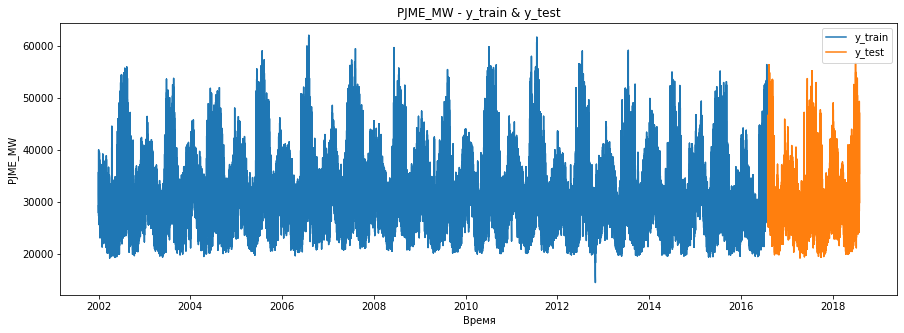

In [20]:
plt.figure( figsize=( 15, 5 ))
plt.xlabel('Время')
plt.ylabel(TARGET_NAME)
plt.plot(X_train.index, y_train, label='y_train' )
plt.plot(X_test.index, y_test, label='y_test')
plt.title(f'{TARGET_NAME} - y_train & y_test' )
plt.legend()
plt.show()

In [21]:
model = GradientBoostingRegressor(max_depth=3, random_state=0, n_estimators=30)

mean absolute percentage error: 2.08%


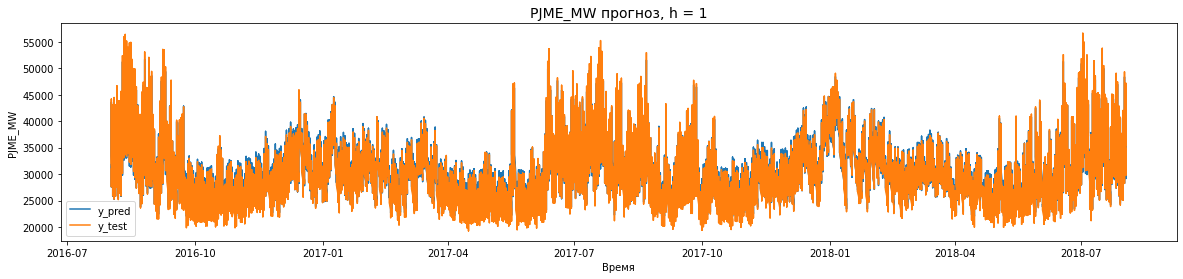

In [22]:
model.fit(X_train, y_train) 
y_pred = model.predict(X_test)

err = mean_absolute_percentage_error(y_test, y_pred)
print(f'mean absolute percentage error: {round(err, 2)}%')

plot_prediction()

mean absolute percentage error: 10.89%


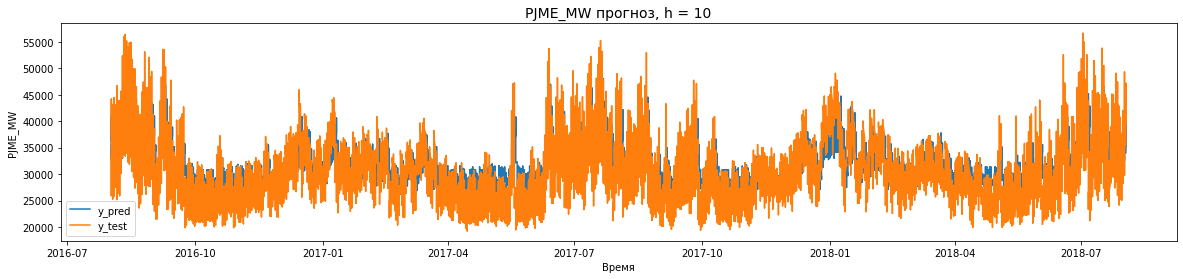

In [23]:
h = 10
X_train, X_test, y_train, y_test = train_test_split(df, split_date, h)
model.fit(X_train, y_train) 
y_pred = model.predict(X_test)

err = mean_absolute_percentage_error(y_test, y_pred)
print(f'mean absolute percentage error: {round(err, 2)}%')

plot_prediction()

### Задание 2.

Оцените ошибки моделей из п.1 .

Модель авторегрессии на шаг вперед (h = 1) дает ошибку 5.62%. При h = 10 ошибка составлет 10.25%

### Задание 3.

Сделайте вывод о том, как изменилась ошибка модели по значениям h.

In [24]:
n = 14
error_log = []
for h in range(1, n+1):
    X_train, X_test, y_train, y_test = train_test_split(df, split_date, h)
    model.fit(X_train, y_train) 
    y_pred = model.predict(X_test)

    err = mean_absolute_percentage_error(y_test, y_pred)
    error_log.append(err) 
    
h_results = pd.DataFrame([[h for h in range(1, n+1)], error_log], index=['h', 'err']).T

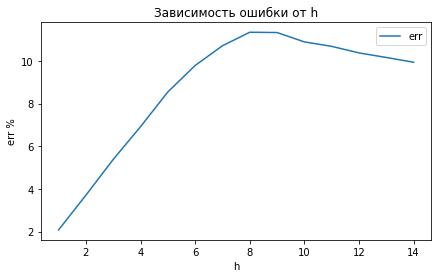

In [25]:
plt.figure( figsize=(7, 4))
plt.xlabel('h')
plt.ylabel('err %')
plt.plot(h_results.h, h_results.err, label='err' )
plt.title('Зависимость ошибки от h')

plt.legend()
plt.show()

При увеличении h ошибка растет, также изменяется темп ее роста

### Задание 4.

Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

а) Изменение температуры за окном :).
б) Количество денег, которые тратят покупатели в интернет магазине.
в) Вес растущего котенка.
г) Прирост объема деревьев в лесу от времени

Все ряды - нестационарные, т.к. в каждом примере присутствует либо сезонность, либо цикличность, либо тренды.